In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import SGD
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision

In [2]:
if torch.cuda.is_available():
  dev = "cuda:0"
else:
  dev = "cpu"
device = torch.device(dev)

In [3]:
device

device(type='cuda', index=0)

In [4]:
my_transform = torchvision.transforms.Compose([torchvision.transforms.Resize((240, 240)), torchvision.transforms.ToTensor()])
from torchvision.datasets import ImageFolder

In [5]:
dataset_path = '/kaggle/input/queensland-dataset-ce42/Queensland Dataset CE42'

In [6]:
dataset_path

'/kaggle/input/queensland-dataset-ce42/Queensland Dataset CE42'

In [7]:

# dataset = ImageFolder(dataset_path, transform = my_transform)

In [8]:
# fig, axs = plt.subplots(1,5, figsize = (15,3))
# for i in range(5):
#     image,target = dataset[i]
#     axs[i].imshow(image.permute(1,2,0))
#     axs[i].set_title('Target: {}'. format(target))
#     axs[i].axis('off')
# plt.show()

In [9]:
# fig, axs = plt.subplots(1,5, figsize = (15,3))
# for i in range(5):
#     image,target = dataset[i + 500]
#     axs[i].imshow(image.permute(1,2,0))
#     axs[i].set_title('Target: {}'. format(target))
#     axs[i].axis('off')
# plt.show()

In [10]:
class myUNet(nn.Module):
    def __init__(self,n_classes):
        super().__init__()
        self.relu = nn.ReLU()
        #Encoder
        self.conv11 = nn.Conv2d(3,64,kernel_size = 3, padding = 1)
        self.conv12 = nn.Conv2d(64, 64, kernel_size = 3, padding =1)
        self.pool11 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.conv21 = nn.Conv2d(64,128,kernel_size = 3, padding = 1)
        self.conv22 = nn.Conv2d(128, 128, kernel_size = 3, padding =1)
        self.pool21 = nn.MaxPool2d(kernel_size = 2, stride = 2)
                
        self.conv31 = nn.Conv2d(128,256,kernel_size = 3, padding = 1)
        self.conv32 = nn.Conv2d(256, 256, kernel_size = 3, padding =1)
        self.pool31 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.conv41 = nn.Conv2d(256,512,kernel_size = 3, padding = 1)
        self.conv42 = nn.Conv2d(512, 512, kernel_size = 3, padding =1)
        self.pool41 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.conv51 = nn.Conv2d(512,1024,kernel_size = 3, padding = 1)
        self.conv52 = nn.Conv2d(1024, 1024, kernel_size = 3, padding =1)
        
        #Decoder
        self.upconv11 = nn.ConvTranspose2d(1024, 512, kernel_size = 2, stride = 2)
        self.dconv11 = nn.Conv2d(1024, 512, kernel_size = 3, padding = 1)
        self.dconv12 = nn.Conv2d(512, 512, kernel_size = 3, padding = 1)
        
        self.upconv21 = nn.ConvTranspose2d(512, 256, kernel_size = 2, stride = 2)
        self.dconv21 = nn.Conv2d(512, 256, kernel_size = 3, padding = 1)
        self.dconv22 = nn.Conv2d(256, 256, kernel_size = 3, padding = 1)
        
        self.upconv31 = nn.ConvTranspose2d(256, 128, kernel_size = 2, stride = 2)
        self.dconv31 = nn.Conv2d(256, 128, kernel_size = 3, padding = 1)
        self.dconv32 = nn.Conv2d(128, 128, kernel_size = 3, padding = 1)
        
        
        self.upconv41 = nn.ConvTranspose2d(128, 64, kernel_size = 2, stride = 2)
        self.dconv41 = nn.Conv2d(128, 64, kernel_size = 3, padding = 1)
        self.dconv42 = nn.Conv2d(64, 64, kernel_size = 3, padding = 1)
        
        #Output Layer
        self.outconv = nn.Conv2d(64, n_classes, kernel_size=1)
        
    def forward(self, x):
        #Encoder Layer
#         print(x.shape)
        x11 = self.relu(self.conv12(self.relu(self.conv11(x))))
#         print (x11.shape)
        x12 = self.pool11(x11)
#         print (x12.shape)
        x21 = self.relu(self.conv22(self.relu(self.conv21(x12))))
#         print(x21.shape)
        x22 = self.pool21(x21)
#         print (x22.shape)
        x31 = self.relu(self.conv32(self.relu(self.conv31(x22))))
#         print(x31.shape)
        x32 = self.pool31(x31)
#         print (x32.shape)
        x41 = self.relu(self.conv42(self.relu(self.conv41(x32))))
#         print(x41.shape)
        x42 = self.pool41(x41)
#         print (x42.shape)
        x51 = self.relu(self.conv52(self.relu(self.conv51(x42))))
#         print (x51.shape)
        #Decoder Layer
        xd11 = torch.cat([self.upconv11(x51),x41], dim = 1)
        xd12 = self.relu(self.dconv12(self.relu(self.dconv11(xd11))))
#         print (xd12.shape)
        xd21 = torch.cat([self.upconv21(xd12),x31], dim = 1)
        xd22 = self.relu(self.dconv22(self.relu(self.dconv21(xd21))))
#         print (xd22.shape)
        xd31 = torch.cat([self.upconv31(xd22),x21], dim = 1)
        xd32 = self.relu(self.dconv32(self.relu(self.dconv31(xd31))))
#         print (xd32.shape)
        xd41 = torch.cat([self.upconv41(xd32),x11], dim = 1)
        xd42 = self.relu(self.dconv42(self.relu(self.dconv41(xd41))))
#         print (xd42.shape)
        #Output Layer
        out = self.outconv(xd42)
        return out

In [11]:
images_dataset_path = '/kaggle/input/queensland-images-dataset/Images_Dataset'
masks_dataset_path = '/kaggle/input/queensland-masks-data/Masks_Dataset'

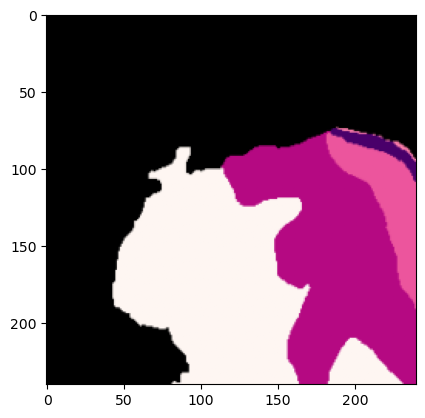

In [12]:
images_dataset = ImageFolder(images_dataset_path, transform=my_transform)
masks_dataset = ImageFolder(masks_dataset_path, transform=my_transform)
image, _ = images_dataset[0]
mask, _ = masks_dataset[0]
mask = mask.permute(1,2,0)
plt.imshow(mask)


In [13]:
# np.unique(mask)

In [14]:
# fig, axs = plt.subplots(1,5, figsize = (15,3))
# for i in range(5):
#     image,target = images_dataset[i]
#     axs[i].imshow(image.permute(1,2,0))
#     axs[i].set_title('Target: {}'. format(target))
#     axs[i].axis('off')
# plt.show()

In [15]:
# fig, axs = plt.subplots(1,5, figsize = (15,3))
# for i in range(5):
#     image,target = masks_dataset[i]
#     axs[i].imshow(image.permute(1,2,0))
#     axs[i].set_title('Target: {}'. format(target))
#     axs[i].axis('off')
# plt.show()

In [16]:
class ImageMaskCorrespondence(Dataset):
    def __init__(self, images_dataset, masks_dataset):
        self.images_dataset = images_dataset
        self.masks_dataset = masks_dataset
        
    def __len__(self):
        return min(len(self.images_dataset), len(self.masks_dataset))
    def __getitem__(self, index):
        image, _ = self.images_dataset[index]
        mask, _ = self.masks_dataset[index]
        return image, mask

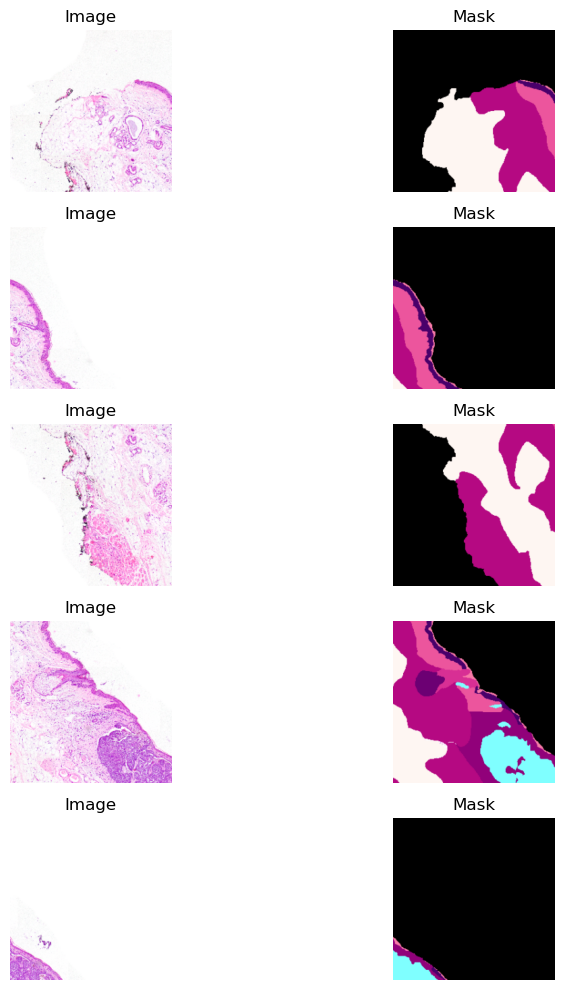

In [17]:
ImageMask_dataset = ImageMaskCorrespondence(images_dataset, masks_dataset)

num_images = 5
fig, axs = plt.subplots(num_images, 2, figsize=(10, 10))
for i in range(num_images):
    image, mask = ImageMask_dataset[i]
    axs[i, 0].imshow(image.permute(1, 2, 0))
    axs[i, 0].set_title('Image')
    axs[i, 0].axis('off')
    
    axs[i, 1].imshow(mask.permute(1, 2, 0))
    axs[i, 1].set_title('Mask')
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [18]:
from sklearn.model_selection import train_test_split
train_dataset, val_dataset = train_test_split(ImageMask_dataset, test_size = 0.2, random_state = 42)
len(train_dataset), len(val_dataset)

(1200, 300)

In [19]:
train_loader = DataLoader(train_dataset, batch_size = 60, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 50, shuffle = True)

In [20]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [21]:
model = myUNet(n_classes = 12).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr = 0.001)
n_epochs = 20
best_val_accuracy = 0.0
best_model_path = 'best_model.pth'
print(device)

cuda:0


In [22]:
from torch.nn.parallel import DataParallel
model = DataParallel(model)

In [23]:
# for epoch in range(n_epochs):
#     model.train()
#     train_loss = 0.0
#     total_loss = 0.0
#     for images, masks in train_loader:
#         images = images.to(device)
#         masks = masks.to(device)
#         masks = masks.squeeze(1)
        
#         optimizer.zero_grad()
#         outputs = model(images)
# #         print('Output shape:', outputs.shape)
# #         print('Masks shape:', masks.shape)
#         masks_one_hot = torch.zeros(masks.size(0), 12, masks.size(2), masks.size(3)).to(device)
#         masks_one_hot.scatter_(1, masks.long(), 1)
#         loss = criterion(outputs, masks_one_hot)
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()
        
#     model.eval()
#     val_loss = 0.0
#     true_labels = []
#     predicted_labels = []
    
#     with torch.no_grad():
#         for images, masks in val_loader:
#             images = images.to(device)
#             masks = masks.to(device)
#             masks = masks.squeeze(1)
            
#             outputs = model(images)
#             masks_one_hot = torch.zeros(masks.size(0), 12, masks.size(2), masks.size(3)).to(device)
#             masks_one_hot.scatter_(1, masks.long(), 1)
#             loss = criterion(outputs, masks_one_hot)
#             val_loss += loss.item()
#             predicted_masks = torch.argmax(outputs, dim = 1)
#             true_labels.extend(masks_one_hot.view(-1).cpu().numpy())
#             predicted_labels.extend(predicted_masks.view(-1).cpu().numpy())
#             print("Length of true_labels:", len(true_labels))
#             print("Length of predicted_labels:", len(predicted_labels))
#     true_labels = np.array(true_labels)
#     predicted_labels = np.array(predicted_labels)
#     print("Final length of true_labels:", len(true_labels))
#     print("Final length of predicted_labels:", len(predicted_labels))
#     last_batch_size = len(val_dataset) % val_loader.batch_size
#     if last_batch_size > 0:
#         true_labels = true_labels[:-last_batch_size]
#         predicted_labels = predicted_labels[:-last_batch_size]
#     avg_val_loss = val_loss / len(val_loader)
#     val_accuracy = accuracy_score(true_labels, predicted_labels)
#     confusion_mat = confusion_matrix(true_labels, predicted_labels)
    
#     if val_accuracy > best_val_accuracy:
#         best_val_accuracy = val_accuracy
#         torch.save(model.state_dict(), best_model_path)
#     print(f"Epoch {epoch+1}/{num_epochs} - "
#           f"Train Loss: {avg_train_loss:.4f} - "
#           f"Val Loss: {avg_val_loss:.4f} - "
#           f"Val Accuracy: {val_accuracy:.4f}")

In [24]:
from matplotlib.colors import ListedColormap

colors = [
    (108, 0, 115),   # Class 0
    (145, 1, 122),   # Class 1
    (216, 47, 148),  # Class 2
    (254, 246, 242), # Class 3
    (181, 9, 130),   # Class 4
    (236, 85, 157),  # Class 5
    (73, 0, 106),    # Class 6
    (248, 123, 168), # Class 7
    (0, 0, 0),       # Class 8 (background)
    (127, 255, 255), # Class 9
    (127, 255, 142), # Class 10
    (255, 127, 127)  # Class 11
]


losses = []
epochs = []
for epoch in range(n_epochs):
    model.train()
    print(f'Epoch {epoch + 1}')
    N = len(train_loader)
    for i, (images, masks) in enumerate(train_loader):
        images = images.to(device)
        masks = masks.to(device)
        masks = masks.squeeze(1)
        masks_indices = torch.argmax(masks, dim=1)
        masks_one_hot = F.one_hot(torch.tensor(masks_indices), num_classes=12).float()
        print('One hot shape 1',masks_one_hot.shape)
        masks_one_hot = masks_one_hot.permute(0, 3, 1, 2)  # Reshape to [batch_size, num_classes, height, width]
        print('One hot shape 2',masks_one_hot.shape)
        optimizer.zero_grad()
        output = model(images)
        print('Output shape',output.shape)
        loss_value = criterion(output, masks_one_hot)
        loss_value.backward()
        optimizer.step()
        epochs.append(epoch + 1/N)
        losses.append(loss_value.item())

    
            

Epoch 1
One hot shape 1 torch.Size([60, 240, 240, 12])
One hot shape 2 torch.Size([60, 12, 240, 240])


/tmp/ipykernel_23/361436620.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  masks_one_hot = F.one_hot(torch.tensor(masks_indices), num_classes=12).float()


Output shape torch.Size([60, 12, 240, 240])
One hot shape 1 torch.Size([60, 240, 240, 12])
One hot shape 2 torch.Size([60, 12, 240, 240])
Output shape torch.Size([60, 12, 240, 240])
One hot shape 1 torch.Size([60, 240, 240, 12])
One hot shape 2 torch.Size([60, 12, 240, 240])
Output shape torch.Size([60, 12, 240, 240])
One hot shape 1 torch.Size([60, 240, 240, 12])
One hot shape 2 torch.Size([60, 12, 240, 240])
Output shape torch.Size([60, 12, 240, 240])
One hot shape 1 torch.Size([60, 240, 240, 12])
One hot shape 2 torch.Size([60, 12, 240, 240])
Output shape torch.Size([60, 12, 240, 240])
One hot shape 1 torch.Size([60, 240, 240, 12])
One hot shape 2 torch.Size([60, 12, 240, 240])
Output shape torch.Size([60, 12, 240, 240])
One hot shape 1 torch.Size([60, 240, 240, 12])
One hot shape 2 torch.Size([60, 12, 240, 240])
Output shape torch.Size([60, 12, 240, 240])
One hot shape 1 torch.Size([60, 240, 240, 12])
One hot shape 2 torch.Size([60, 12, 240, 240])
Output shape torch.Size([60, 12, 2

In [25]:
epoch_data_avg = np.array(epochs).reshape(20, -1).mean(axis=1)
loss_data_avg = np.array(losses).reshape(20, -1).mean(axis=1)

Text(0.5, 1.0, 'Cross Entropy (averaged per Epoch)')

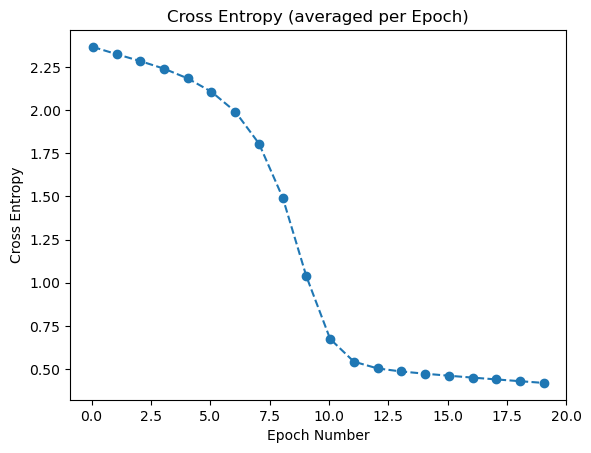

In [26]:

plt.plot(epoch_data_avg, loss_data_avg, 'o--')
plt.xlabel('Epoch Number')
plt.ylabel('Cross Entropy')
plt.title('Cross Entropy (averaged per Epoch)')

tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 0.9961, 1.0000, 1.0000]],

        [[0.7608, 0.7922, 0.7843,  ..., 0.7020, 0.6431, 0.6824],
         [0.7882, 0.8118, 0.8078,  ..., 0.7686, 0.7176, 0.8196],
         [0.7647, 0.7608, 0.7882,  ..., 0.7608, 0.7765, 0.7804],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 0.9961, 1.0000, 1.0000]],

        [[0.9843, 0.9882, 1.0000,  ..., 0.9373, 0.9412, 0.9686],
         [1.0000, 0.9882, 0.9922,  ..., 0.9647, 0.9451, 0.9529],
         [0.9882, 0.9843, 0.9843,  ..., 0.9843, 0.9843, 0.

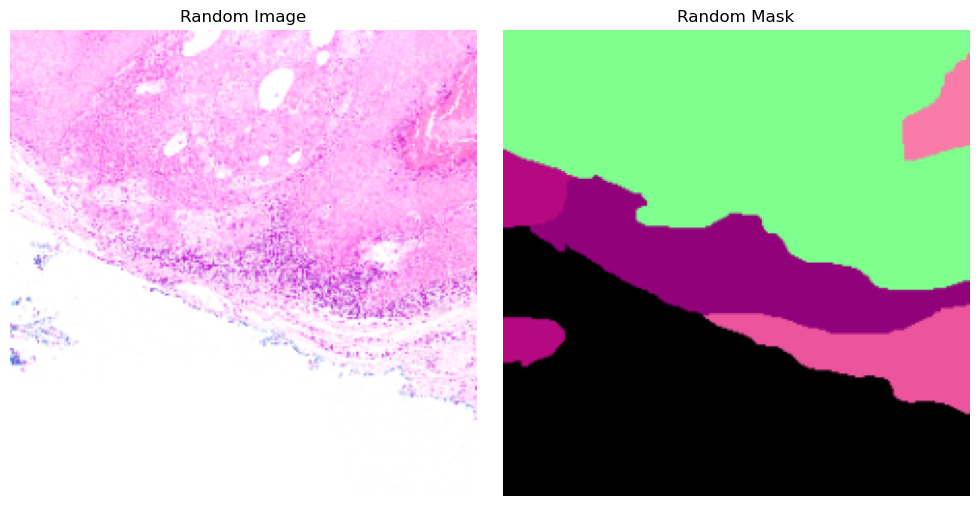

In [27]:
random_img, random_mask = val_dataset[0]
print(random_img)
print(random_mask)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(random_img.permute(1, 2, 0))
plt.title('Random Image')
plt.axis('off')

# Plot the random mask
plt.subplot(1, 2, 2)
plt.imshow(random_mask.permute(1,2,0)) 
plt.title('Random Mask')
plt.axis('off')

plt.tight_layout()
plt.show()

In [28]:
print(random_mask.shape)
random_mask = random_mask.unsqueeze(0)
print(random_mask.shape)
masks_indices = torch.argmax(random_mask, dim=1)
print(masks_indices.shape)
random_mask_ohe = F.one_hot(torch.tensor(masks_indices), num_classes=12).float()
print(random_mask_ohe.shape)
random_mask_ohe = random_mask_ohe.permute(0,3,1,2)
print(random_mask_ohe.shape)


torch.Size([3, 240, 240])
torch.Size([1, 3, 240, 240])
torch.Size([1, 240, 240])
torch.Size([1, 240, 240, 12])
torch.Size([1, 12, 240, 240])


/tmp/ipykernel_23/3912283359.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  random_mask_ohe = F.one_hot(torch.tensor(masks_indices), num_classes=12).float()


In [29]:
print(device)
random_mask_ohe = random_mask_ohe.to(device)
with torch.no_grad():
    model.eval()
    output = model(random_img.unsqueeze(0).to(device))  # Assuming random_img is your input image tensor
    output_indices = torch.argmax(output, dim=1)  # Obtain predicted class indices
    output_ohe = F.one_hot(output_indices, num_classes=12).float()  # Convert class indices to one-hot tensor
    print(output_ohe.shape)
    output_ohe = output_ohe.permute(0,3,1,2)
    print(random_mask_ohe.shape)
intersection = torch.logical_and(output_ohe, random_mask_ohe)
union = torch.logical_or(output_ohe, random_mask_ohe)
iou = torch.sum(intersection) / torch.sum(union)

print("Intersection over Union:", iou.item())

output_indices = output_indices.view(-1).cpu().numpy()
mask_indices = masks_indices.view(-1).cpu().numpy()
accuracy = accuracy_score(mask_indices, output_indices)
print('Accuracy: ', accuracy)

cuda:0
torch.Size([1, 240, 240, 12])
torch.Size([1, 12, 240, 240])
Intersection over Union: 0.4183523952960968
Accuracy:  0.5899131944444445


In [30]:
accuracy_list = []
all_predicted = []
all_true = []
images = []
true_masks = []
pred_masks = []
model.eval()
for data in val_loader:
    img, mask = data
    img = img.to(device)
    mask = mask.to(device)
    output = model(img)
    output_indices = torch.argmax(output, dim = 1)
    output_indices = output_indices.view(-1).cpu().numpy()
    mask_indices = torch.argmax(mask, dim = 1)
    mask_indices = mask_indices.view(-1).cpu().numpy()
    pred_mask = torch.argmax(output, dim = 1).squeeze().cpu().numpy()
    print(pred_mask.shape)
    accuracy = accuracy_score(mask_indices, output_indices)
    accuracy_list.append(accuracy)
    all_predicted.extend(output_indices)
    all_true.extend(mask_indices)
    images.extend(img.cpu().numpy())
    true_masks.extend(mask.cpu().numpy())
    pred_masks.extend(pred_mask)
average_accuracy=sum(accuracy_list)/len(accuracy_list)
cm = confusion_matrix(all_true, all_predicted)
print('Average Accuracy: ', average_accuracy)
print('Confusion Matrix: ', cm)

(50, 240, 240)
(50, 240, 240)
(50, 240, 240)
(50, 240, 240)
(50, 240, 240)
(50, 240, 240)
Average Accuracy:  0.9227919560185186
Confusion Matrix:  [[15945845        0        0]
 [ 1075249        0        0]
 [  258906        0        0]]


In [31]:
# from matplotlib.colors import BoundaryNorm
# cmap = ListedColormap(colors)
# num_classes = 12
# bounds = list(range(num_classes + 1))
# norm = BoundaryNorm(bounds, cmap.N)

# num_images = 5

# fig, axes = plt.subplots(num_images, 2, figsize=(10, 10))
# for i in range(num_images):
#     axes[i, 0].imshow(images[i].permute(1, 2, 0).cpu().numpy())
#     axes[i, 0].axis('off')
#     axes[i, 0].set_title("Image")
#     axes[i, 1].imshow(true_masks[i].permute(1, 2, 0).cpu().numpy())
#     axes[i, 1].axis('off')
#     axes[i, 1].set_title("True Mask")
# plt.tight_layout()
# plt.show()

# fig, axes = plt.subplots(num_images, 2, figsize=(10, 10))
# for i in range(num_images):
#     axes[i, 0].imshow(images[i].permute(1, 2, 0).cpu().numpy())
#     axes[i, 0].axis('off')
#     axes[i, 0].set_title("Image")
#     print(pred_mask[i].shape)
#     pred_mask = pred_masks[i].argmax(dim=0).cpu().numpy()
    
#     pred_mask_rgb = np.zeros((pred_mask.shape[0], pred_mask.shape[1], 3), dtype=np.uint8)
#     for class_index, color in enumerate(colors):
#         if class_index in pred_mask:
#             pred_mask_rgb[pred_mask == class_index] = color
    
#     axes[i, 1].imshow(pred_mask_rgb)
#     axes[i, 1].axis('off')
#     axes[i, 1].set_title("Predicted Mask")
# plt.tight_layout()
# plt.show()

In [32]:
del model
del optimizer
torch.cuda.empty_cache()

In [33]:
# FOR CLASSIFICATION
# Using VGG16 
from torchvision import models

my_classification_transform = torchvision.transforms.Compose([torchvision.transforms.Resize((224, 224)), torchvision.transforms.ToTensor()])

classification_dataset = ImageFolder(images_dataset_path, transform = my_classification_transform)
label_names = classification_dataset.classes
print(label_names)

['BCC', 'IEC', 'SCC']


In [34]:
vgg16 = models.vgg16(pretrained = True)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 275MB/s]


In [35]:
vgg16


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [36]:
#Freezing weights
for param in vgg16.parameters():
    param.requires_grad = False
vgg16.classifier[6] = nn.Linear(4096, 3)
for name, param in vgg16.named_parameters():
    if param.requires_grad == True:
        print(name)

classifier.6.weight
classifier.6.bias


In [37]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [38]:
classification_train_dataset, classification_test_dataset = train_test_split(classification_dataset, test_size = 0.2, random_state = 42)

from torch.utils.data import random_split
random_seed = 20
torch.manual_seed(random_seed)
val_size = 200
train_size = len(classification_train_dataset) - val_size
classification_train_dataset, validation_dataset = random_split(classification_train_dataset, [train_size, val_size])
len(classification_train_dataset), len(classification_test_dataset), len(validation_dataset)

(1000, 300, 200)

In [39]:
train_dl = DataLoader(classification_train_dataset, batch_size = 50, shuffle = True)
test_dl = DataLoader(classification_test_dataset, batch_size = 50, shuffle = False)
val_dl = DataLoader(validation_dataset, batch_size = 50, shuffle = False)

In [40]:
classification_criterion = nn.CrossEntropyLoss()
classification_optimizer = SGD(vgg16.parameters(), lr = 0.001)

In [41]:
!pip install torchsummary

In [42]:
from torch.utils.tensorboard import SummaryWriter
from torchsummary import summary
n_epochs = 100
train_losses = []
val_losses = []
best_accuracy=0
vgg16.to(device)
vgg16 = DataParallel(vgg16)
tboardWriter=SummaryWriter('runs/VGG16ClassificationforDipProject-CNN')
for epoch in range(n_epochs):
    all_Y_train_epoch=np.array([]).reshape(0,1)
    all_Yhat_train_epoch=np.array([]).reshape(0,1)
    all_train_losses_epoch=np.array([])
    
    for X_train, Y_train in train_dl:        #batch wise  training on train set
        vgg16.train()
        X_train = X_train.to(device)
        Y_train = Y_train.to(device)  
        logits = vgg16(X_train)               
        
        loss = classification_criterion(logits, Y_train)       
        loss.backward()
        classification_optimizer.step()
        classification_optimizer.zero_grad()
        
        y_hat=F.softmax(logits,dim=-1)
        y_hat=y_hat.detach().cpu().numpy()
        y_hat=np.argmax(y_hat,axis=1)
        y_hat=y_hat.reshape(-1,1)

        Y_train=Y_train.detach().cpu().numpy()
        Y_train=Y_train.reshape(-1,1)
        all_Y_train_epoch=np.vstack((all_Y_train_epoch,Y_train))
        all_Yhat_train_epoch=np.vstack((all_Yhat_train_epoch,y_hat))   
        all_train_losses_epoch=np.append(all_train_losses_epoch,loss.item())   
        
    train_losses.append(all_train_losses_epoch.mean()) #mean loss for all batches    
    acTrain=accuracy_score(all_Y_train_epoch, all_Yhat_train_epoch)
    cmTrain=confusion_matrix(all_Y_train_epoch, all_Yhat_train_epoch)
    print(cmTrain)
        
    all_Y_val_epoch=np.array([]).reshape(0,1)
    all_Yhat_val_epoch=np.array([]).reshape(0,1)
    all_val_losses_epoch=np.array([])
    for X_val, Y_val in val_dl:
        vgg16.eval()
        
        X_val = X_val.to(device)
        Y_val = Y_val.to(device)

        with torch.no_grad():            
            logits = vgg16(X_val)           
            loss = classification_criterion(logits, Y_val)
        y_hat_val=F.softmax(logits,dim=-1)
        y_hat_val=y_hat_val.detach().cpu().numpy()
        y_hat_val=np.argmax(y_hat_val,axis=1)
        y_hat_val=y_hat_val.reshape(-1,1)
        Y_val=Y_val.detach().cpu().numpy()
        Y_val=Y_val.reshape(-1,1)
        all_Y_val_epoch=np.vstack((all_Y_val_epoch,Y_val))
        all_Yhat_val_epoch=np.vstack((all_Yhat_val_epoch,y_hat_val))   
        all_val_losses_epoch=np.append(all_val_losses_epoch,loss.item())     
    val_losses.append(all_val_losses_epoch.mean()) #mean loss for all batches    
    acVal=accuracy_score(all_Y_val_epoch, all_Yhat_val_epoch)
    cmVal=confusion_matrix(all_Y_val_epoch, all_Yhat_val_epoch)
    print(f"epoch= {epoch}, accuracyTrain= {acTrain}, accuracyVal= {acVal}, train_loss= {train_losses[epoch]}, validation_loss= {val_losses[epoch]}")
    #checkpointing training
    if(acVal>best_accuracy):
        checkpoint = {'epoch': epoch,'model_state_dict': vgg16.state_dict(),
                      'optimizer_state_dict': classification_optimizer.state_dict(),'loss': train_losses,
                      'val_loss': val_losses}
        torch.save(checkpoint,'best.pth')
    
    tboardWriter.add_scalar("Loss/train", train_losses[epoch], epoch)
    tboardWriter.add_scalar("Loss/val", val_losses[epoch], epoch)
    tboardWriter.add_scalar("accuracy/train", acTrain, epoch)
    tboardWriter.add_scalar("accuracy/val", acVal, epoch)
    
checkpoint = torch.load('best.pth')
# Restore state for model and optimizer
vgg16.load_state_dict(checkpoint['model_state_dict'])
classification_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
total_epochs = checkpoint['epoch']
losses = checkpoint['loss']
val_losses = checkpoint['val_loss']

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

[[106 114 108]
 [124 118 104]
 [126 101  99]]
epoch= 0, accuracyTrain= 0.323, accuracyVal= 0.355, train_loss= 1.1267840087413787, validation_loss= 1.0977272391319275
[[103 131  94]
 [109 156  81]
 [111 129  86]]
epoch= 1, accuracyTrain= 0.345, accuracyVal= 0.425, train_loss= 1.1091913878917694, validation_loss= 1.090835452079773
[[ 88 124 116]
 [ 84 158 104]
 [ 73 109 144]]
epoch= 2, accuracyTrain= 0.39, accuracyVal= 0.41, train_loss= 1.0946426928043365, validation_loss= 1.0831495225429535
[[128 109  91]
 [114 162  70]
 [ 88 107 131]]
epoch= 3, accuracyTrain= 0.421, accuracyVal= 0.46, train_loss= 1.0768194913864135, validation_loss= 1.0784702599048615
[[113 120  95]
 [107 157  82]
 [ 92  98 136]]
epoch= 4, accuracyTrain= 0.406, accuracyVal= 0.445, train_loss= 1.0734138250350953, validation_loss= 1.0760812759399414
[[104 151  73]
 [ 96 177  73]
 [ 79 108 139]]
epoch= 5, accuracyTrain= 0.42, accuracyVal= 0.45, train_loss= 1.0645248115062713, validation_loss= 1.069901943206787
[[ 94 155  

In [43]:
def test_model(model, test_dataloader):
    model.eval()
    all_Y_test = np.array([]).reshape(0, 1)
    all_Yhat_test = np.array([]).reshape(0, 1)

    for X_test, Y_test in test_dataloader:
        X_test = X_test.to(device)
        Y_test = Y_test.to(device)

        with torch.no_grad():
            logits = model(X_test)
            y_hat_test = F.softmax(logits, dim=-1)
            y_hat_test = torch.argmax(y_hat_test, dim=1)
            y_hat_test = y_hat_test.detach().cpu().numpy().reshape(-1, 1)
            Y_test = Y_test.detach().cpu().numpy().reshape(-1, 1)

        all_Y_test = np.vstack((all_Y_test, Y_test))
        all_Yhat_test = np.vstack((all_Yhat_test, y_hat_test))

    accuracy_test = accuracy_score(all_Y_test, all_Yhat_test)
    cm_test = confusion_matrix(all_Y_test, all_Yhat_test)

    print("Testing results:")
    print("Confusion Matrix:")
    print(cm_test)
    print("Accuracy:", accuracy_test)

    return all_Y_test, all_Yhat_test, accuracy_test, cm_test

In [44]:
all_Y_test, all_Yhat_test, accuracy_test, cm_test = test_model(vgg16, test_dl)

Testing results:
Confusion Matrix:
[[41 45 18]
 [20 59  7]
 [16 32 62]]
Accuracy: 0.54
